In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow --quiet

In [ ]:
# Import libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Import libraries for working with dates and times
import datetime as dt

# Import TensorFlow and Keras libraries for building and training neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Reshape, Flatten
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

# Import scikit-learn library for various metrics and preprocessing tools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Import matplotlib library for creating plots and charts
import matplotlib.pyplot as plt

# Magic command to display plots inline in the Jupyter Notebook
%matplotlib inline

In [ ]:
# Calculate the accuracy of each model
def evaluateModel(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [ ]:
# Read in the Silver dataset from a CSV file
df=pd.read_csv("/content/drive/MyDrive/PTDLKD/Data/Silver_Data.csv")
df=df.set_index(pd.DatetimeIndex(df['Date'].values))


# Preprocessing Data

---

In [ ]:
# Format column Date
df.index = pd.to_datetime(df.index,format='%m/%d/%Y')

# Flip the column
df = df.iloc[::-1]

# Create new Dataframe
df1 = pd.DataFrame(df, columns=['Date', 'Price'])
df1.drop('Date', axis = 1, inplace = True)

# Plot the 'price' column of the 'df' DataFrame
plt.figure(figsize=(16,5))
plt.plot(df1['Price'])
plt.title('Prices of Silver')
plt.show()

# Split dataset (7-2-1)

---



In [ ]:
# Create a MinMaxScaler object with a specified range
data = df1.values
sc = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler to the data and transform the data
sc_train = sc.fit_transform(data)

# Split the data
train_size = int(0.7 * len(sc_train))
test_size = int(0.2 * len(sc_train))
val_size = len(sc_train) - train_size - test_size

train_data = sc_train[:train_size]
test_data = sc_train[train_size:train_size+test_size]
val_data = sc_train[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(100, len(train_data)):
    # Append the last 100 values to the x_train array
    x_train.append(sc_train[i-100:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an LSTM layer with 50 units
model.add(LSTM(50,return_sequences=True))

# Add an LSTM layer with 50 units
model.add(LSTM(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_7_2_1.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_7_2_1.hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

28/28 [==============================] - 3s 60ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

9/9 [==============================] - 0s 42ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 44ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 100)
[0.673977105292984, 0.6842343873965769, 0.6893913634818088, 0.6665533265329252, 0.6778306698401902, 0.68366768672787, 0.6708035815482262, 0.67114360194945, 0.6025728210359288, 0.5930522498016545, 0.589652045789414, 0.603422872038989, 0.5877252635158109, 0.5838716989686047, 0.5712342740564432, 0.5724243454607275, 0.5553666553326532, 0.563187124560807, 0.5634704748951603, 0.5568400770712908, 0.5687407911141334, 0.5733877365975292, 0.5613170123540744, 0.5402924175450526, 0.5121840643771959, 0.5042502550153009, 0.5207412444746683, 0.5206279043409271, 0.5096905814348859, 0.5364388529978464, 0.522044656012694, 0.4693414938229624, 0.4665646605462993, 0.4676980618837129, 0.48753258528845056, 0.5678907401110732, 0.5755978692054854, 0.5668140088405303, 0.5562733764025841, 0.5995126374249119, 0.6098265895953757, 0.5979825456194038, 0.617873739091012, 0.6444520004533604, 0.6502890173410404, 0.6405417658392835, 0.6558426838943668, 0.658449506970418, 0.6923382069590841, 0.7018021081264875, 

In [ ]:
# Initialize variables
lst_output = []
n_steps = 100
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 100):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.7152999639511108], [0.7101430892944336], [0.7049061059951782], [0.7017658352851868], [0.7005170583724976], [0.7002285122871399], [0.6999776363372803], [0.699225127696991], [0.6978554129600525], [0.6960287690162659], [0.6939955949783325], [0.6919651031494141], [0.6900524497032166], [0.6882848739624023], [0.6866384148597717], [0.6850742101669312], [0.683560311794281], [0.6820812821388245], [0.680634617805481], [0.6792245507240295], [0.6778560876846313], [0.6765304803848267], [0.6752463579177856], [0.6739996075630188], [0.6727855205535889], [0.6715992093086243], [0.6704370379447937], [0.6692967414855957], [0.6681767106056213], [0.6670756936073303]]


In [ ]:
# Convert the 'date' column in the dataframe to a list of strings
datelist_train = df['Date'].astype(str).tolist()

# Parse the date strings using strptime(), using the correct format string
datelist_train = [dt.datetime.strptime(date, '%m/%d/%Y').date() for date in datelist_train]

# Generate a list of future dates, starting from the last date in the training data and going for 15 days
datelist_future = pd.date_range(datelist_train[-1], periods=30, freq='1d').tolist()

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.4401796868506898
MAPE:  2.0203269481421824
RMSE:  0.5403782397684737

** Validate **
MAE:  0.4141448595807269
MAPE:  1.7871500173538366
RMSE:  0.5136371142317261


# Split dataset (6-3-1)

---



In [ ]:
# 4. Split data (6-3-1)
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(100, len(train_data)):
    # Append the last 100 values to the x_train array
    x_train.append(sc_train[i-100:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an LSTM layer with 50 units
model.add(LSTM(50,return_sequences=True))

# Add an LSTM layer with 50 units
model.add(LSTM(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_6_3_1.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.14630, saving model to save_model_6_3_1.hdf5
15/15 - 10s - loss: 0.1463 - 10s/epoch - 665ms/step
Epoch 2/80

Epoch 2: loss improved from 0.14630 to 0.05633, saving model to save_model_6_3_1.hdf5
15/15 - 2s - loss: 0.0563 - 2s/epoch - 165ms/step
Epoch 3/80

Epoch 3: loss improved from 0.05633 to 0.04332, saving model to save_model_6_3_1.hdf5
15/15 - 3s - loss: 0.0433 - 3s/epoch - 168ms/step
Epoch 4/80

Epoch 4: loss improved from 0.04332 to 0.03669, saving model to save_model_6_3_1.hdf5
15/15 - 3s - loss: 0.0367 - 3s/epoch - 193ms/step
Epoch 5/80

Epoch 5: loss did not improve from 0.03669
15/15 - 4s - loss: 0.0369 - 4s/epoch - 272ms/step
Epoch 6/80

Epoch 6: loss improved from 0.03669 to 0.03647, saving model to save_model_6_3_1.hdf5
15/15 - 3s - loss: 0.0365 - 3s/epoch - 168ms/step
Epoch 7/80

Epoch 7: loss improved from 0.03647 to 0.03361, saving model to save_model_6_3_1.hdf5
15/15 - 3s - loss: 0.0336 - 3s/epoch - 168ms/step
Epoch 8/8

In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_6_3_1.hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

24/24 [==============================] - 2s 41ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 1s 41ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

5/5 [==============================] - 0s 42ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 100)
[0.673977105292984, 0.6842343873965769, 0.6893913634818088, 0.6665533265329252, 0.6778306698401902, 0.68366768672787, 0.6708035815482262, 0.67114360194945, 0.6025728210359288, 0.5930522498016545, 0.589652045789414, 0.603422872038989, 0.5877252635158109, 0.5838716989686047, 0.5712342740564432, 0.5724243454607275, 0.5553666553326532, 0.563187124560807, 0.5634704748951603, 0.5568400770712908, 0.5687407911141334, 0.5733877365975292, 0.5613170123540744, 0.5402924175450526, 0.5121840643771959, 0.5042502550153009, 0.5207412444746683, 0.5206279043409271, 0.5096905814348859, 0.5364388529978464, 0.522044656012694, 0.4693414938229624, 0.4665646605462993, 0.4676980618837129, 0.48753258528845056, 0.5678907401110732, 0.5755978692054854, 0.5668140088405303, 0.5562733764025841, 0.5995126374249119, 0.6098265895953757, 0.5979825456194038, 0.617873739091012, 0.6444520004533604, 0.6502890173410404, 0.6405417658392835, 0.6558426838943668, 0.658449506970418, 0.6923382069590841, 0.7018021081264875, 

In [ ]:
# Initialize variables
lst_output = []
n_steps = 100
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 100):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.732245922088623], [0.7417645454406738], [0.7510373592376709], [0.7607364058494568], [0.7712329626083374], [0.7823672294616699], [0.7937495708465576], [0.8050039410591125], [0.8158753514289856], [0.8262360692024231], [0.8360394239425659], [0.8452702164649963], [0.8539127111434937], [0.8619399666786194], [0.869317889213562], [0.8760152459144592], [0.8820100426673889], [0.8872944116592407], [0.8918736577033997], [0.8957648873329163], [0.8989942073822021], [0.901595413684845], [0.9036082029342651], [0.9050763845443726], [0.9060473442077637], [0.9065704345703125], [0.9066951274871826], [0.9064711332321167], [0.9059469699859619], [0.9051685333251953]]


In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[24.69321154]
 [24.86117717]
 [25.02480524]
 [25.19595462]
 [25.38117686]
 [25.57765213]
 [25.77850493]
 [25.97709954]
 [26.16893645]
 [26.35176168]
 [26.52475167]
 [26.68763824]
 [26.8401437 ]
 [26.98179265]
 [27.11198347]
 [27.23016503]
 [27.33594921]
 [27.42919719]
 [27.51000256]
 [27.5786672 ]
 [27.63565178]
 [27.68155267]
 [27.71707035]
 [27.74297788]
 [27.76011144]
 [27.76934189]
 [27.77154222]
 [27.76758962]
 [27.75834023]
 [27.74460394]]


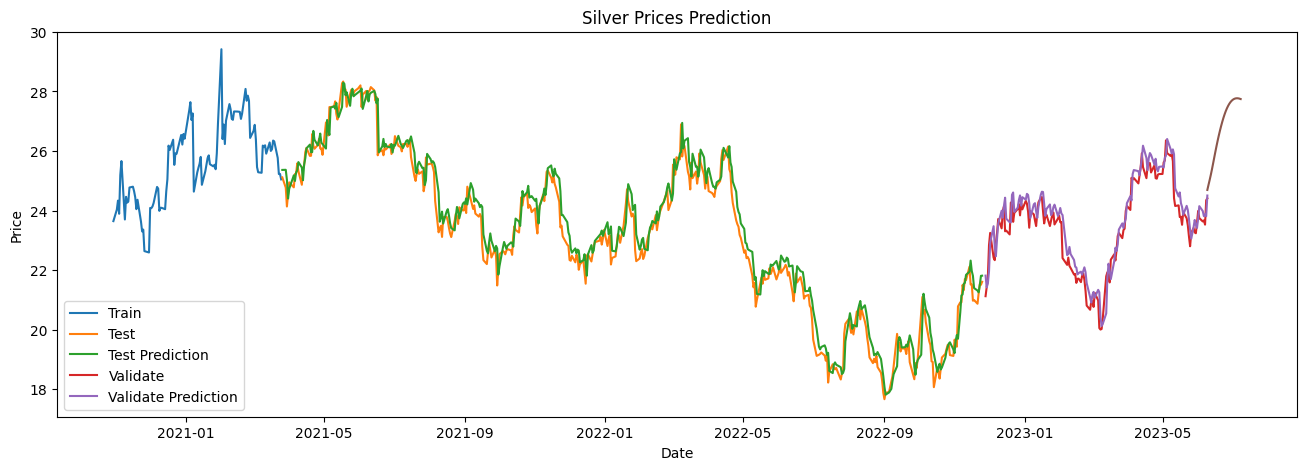

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.3691010222884844
MAPE:  1.6279234692660154
RMSE:  0.477589530289548

** Validate **
MAE:  0.3735409127893582
MAPE:  1.6119094304327293
RMSE:  0.47348973653964205


# Split dataset (5-3-2)

---



In [ ]:
# Split data
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# Create training datasets for the model
x_train, y_train = [], []

# Loop through the train data, starting from the 5th value
for i in range(100, len(train_data)):
    # Append the last 100 values to the x_train array
    x_train.append(sc_train[i-100:i, 0])
    # Append the current value to the y_train array
    y_train.append(sc_train[i, 0])

In [ ]:
# Convert the x_train and y_train arrays to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the x_train and y_train arrays to be one-dimensional
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

In [ ]:
# Build the model
model = Sequential()

# Add an LSTM layer with 50 units, input shape of (x_train.shape[1], 1), and return_sequences set to True
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))

# Add an LSTM layer with 50 units
model.add(LSTM(50,return_sequences=True))

# Add an LSTM layer with 50 units
model.add(LSTM(50))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Compile the model with the 'mean_absolute_error' loss function and the 'adam' optimizer
model.compile(loss='mean_absolute_error', optimizer='adam')
# Set the filename to use for saving the model
save_model = 'save_model_5_3_2.hdf5'

# Create a ModelCheckpoint object to save the model during training
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Train the model using the 'fit' method
model.fit(x_train, y_train, epochs=80, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/80

Epoch 1: loss improved from inf to 0.12967, saving model to save_model_5_3_2.hdf5
13/13 - 8s - loss: 0.1297 - 8s/epoch - 611ms/step
Epoch 2/80

Epoch 2: loss improved from 0.12967 to 0.05571, saving model to save_model_5_3_2.hdf5
13/13 - 2s - loss: 0.0557 - 2s/epoch - 170ms/step
Epoch 3/80

Epoch 3: loss improved from 0.05571 to 0.04237, saving model to save_model_5_3_2.hdf5
13/13 - 4s - loss: 0.0424 - 4s/epoch - 282ms/step
Epoch 4/80

Epoch 4: loss improved from 0.04237 to 0.03645, saving model to save_model_5_3_2.hdf5
13/13 - 2s - loss: 0.0365 - 2s/epoch - 188ms/step
Epoch 5/80

Epoch 5: loss improved from 0.03645 to 0.03100, saving model to save_model_5_3_2.hdf5
13/13 - 2s - loss: 0.0310 - 2s/epoch - 164ms/step
Epoch 6/80

Epoch 6: loss did not improve from 0.03100
13/13 - 2s - loss: 0.0323 - 2s/epoch - 164ms/step
Epoch 7/80

Epoch 7: loss improved from 0.03100 to 0.02927, saving model to save_model_5_3_2.hdf5
13/13 - 2s - loss: 0.0293 - 2s/epoch - 169ms/step
Epoch 8/80


In [ ]:
# Transform the y_train array back to the original scale
y_train = sc.inverse_transform(y_train)

# Load the best model from the save_model.hdf5 file
final_model = load_model('save_model_5_3_2.hdf5')

# Use the model to make predictions on the x_train data
y_train_predict = final_model.predict(x_train)

# Transform the y_train_predict array back to the original scale
y_train_predict = sc.inverse_transform(y_train_predict)

19/19 [==============================] - 2s 43ms/step


In [ ]:
# Preprocess the test data
test = df1[len(train_data)-100:train_size+test_size].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

# Create the x_test array for the test data
x_test = []
for i in range(100, test.shape[0]):
    x_test.append(sc_test[i-100:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the true values for the test data
y_test = data[train_size:train_size+test_size]  # True values

# Use the model to make predictions on the x_test data
y_test_predict = final_model.predict(x_test)

# Transform the y_test_predict array back to the original scale
y_test_predict = sc.inverse_transform(y_test_predict)  # Predicted values

14/14 [==============================] - 1s 42ms/step


In [ ]:
# Preprocess the validate data
val = df1[train_size+test_size-100:].values
val = val.reshape(-1, 1)
sc_val = sc.transform(val)

# Create the x_val array for the validate data
x_val = []
for i in range(100, val.shape[0]):
    x_val.append(sc_val[i-100:i, 0])
x_val = np.array(x_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

# Get the true values for the validate data
y_val = data[train_size+test_size:]  # True values

# Use the model to make predictions on the x_val data
y_val_predict = final_model.predict(x_val)

# Transform the y_val_predict array back to the original scale
y_val_predict = sc.inverse_transform(y_val_predict)  # Predicted values

9/9 [==============================] - 0s 43ms/step


In [ ]:
# Create an input array using the last 10 days of the scaled test data
x_input = sc_train[len(sc_train) - 100:].reshape(1, -1)

# Print the shape of the input array
print(x_input.shape)

# Convert x_input to a list and extract the first element
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Print the temp_input variable
print(temp_input)

(1, 100)
[0.673977105292984, 0.6842343873965769, 0.6893913634818088, 0.6665533265329252, 0.6778306698401902, 0.68366768672787, 0.6708035815482262, 0.67114360194945, 0.6025728210359288, 0.5930522498016545, 0.589652045789414, 0.603422872038989, 0.5877252635158109, 0.5838716989686047, 0.5712342740564432, 0.5724243454607275, 0.5553666553326532, 0.563187124560807, 0.5634704748951603, 0.5568400770712908, 0.5687407911141334, 0.5733877365975292, 0.5613170123540744, 0.5402924175450526, 0.5121840643771959, 0.5042502550153009, 0.5207412444746683, 0.5206279043409271, 0.5096905814348859, 0.5364388529978464, 0.522044656012694, 0.4693414938229624, 0.4665646605462993, 0.4676980618837129, 0.48753258528845056, 0.5678907401110732, 0.5755978692054854, 0.5668140088405303, 0.5562733764025841, 0.5995126374249119, 0.6098265895953757, 0.5979825456194038, 0.617873739091012, 0.6444520004533604, 0.6502890173410404, 0.6405417658392835, 0.6558426838943668, 0.658449506970418, 0.6923382069590841, 0.7018021081264875, 

In [ ]:
# Initialize variables
lst_output = []
n_steps = 100
i = 0

# Loop through the next 30 days
while(i < 30):
    # If the length of temp_input is greater than 30, use the first 30 elements to make a prediction
    if(len(temp_input) > 100):
        # Extract the first 3 elements of temp_input and reshape them for input to the model
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, -1))
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list and remove the first element
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1
    # If the length of temp_input is less than 30, use the entire list to make a prediction
    else:
        # Reshape temp_input for input to the model
        x_input = x_input.reshape((1, n_steps, 1))

        # Make a prediction using the model
        yhat = model.predict(x_input, verbose=0)

        # Add the prediction to the temp_input list
        temp_input.extend(yhat[0].tolist())

        # Add the prediction to the lst_output list
        lst_output.extend(yhat.tolist())
        i += 1

# Print the final list of predictions
print(lst_output)

[[0.7665135860443115], [0.8023409247398376], [0.8331578969955444], [0.8539908528327942], [0.8684952855110168], [0.8834185600280762], [0.9043817520141602], [0.9324009418487549], [0.9633729457855225], [0.9908187389373779], [1.0100184679031372], [1.0208278894424438], [1.0273828506469727], [1.0349748134613037], [1.0463610887527466], [1.0601844787597656], [1.0724828243255615], [1.0799219608306885], [1.0822703838348389], [1.0824189186096191], [1.084132194519043], [1.0893687009811401], [1.0971884727478027], [1.1048965454101562], [1.1103078126907349], [1.1133553981781006], [1.1159342527389526], [1.1202833652496338], [1.1272605657577515], [1.1358211040496826]]


In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Print the inverse transformed list of predictions
print(y_pred_future)

[[25.29789874]
 [25.93010796]
 [26.47390425]
 [26.84152259]
 [27.09746781]
 [27.36080391]
 [27.7307204 ]
 [28.22514702]
 [28.771679  ]
 [29.25598747]
 [29.59478588]
 [29.78552894]
 [29.90119778]
 [30.03516556]
 [30.23608777]
 [30.48001531]
 [30.69703192]
 [30.82830292]
 [30.86974319]
 [30.87236424]
 [30.9025967 ]
 [30.9950001 ]
 [31.13298779]
 [31.26900444]
 [31.36449166]
 [31.41826936]
 [31.46377582]
 [31.54052026]
 [31.66363994]
 [31.8146992 ]]


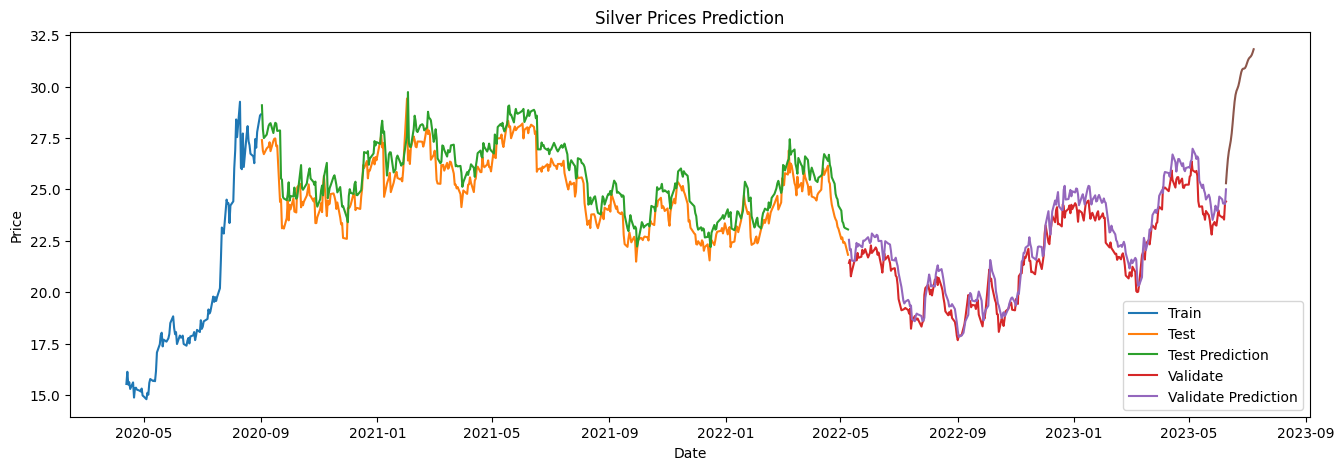

In [ ]:
# Inverse transform the lst_output list using the StandardScaler object
y_pred_future = sc.inverse_transform(lst_output)

# Create a dataframe for the future predictions, with the date as the index and the 'price' column
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['price']).set_index(pd.Series(datelist_future))

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

# Set the figure size and create a subplot
plt.figure(figsize=(16,5))

# Create a plot to compare the predicted and true values for the training and test data
plt.plot(train_data.index[train_size-100:], train_data.Price[train_size-100:])
plt.plot(test_data)

# Plot the actual and predicted prices in the test set, and the predicted future prices
plt.plot(test_data.index, y_test_predict)
plt.plot(val_data)
plt.plot(val_data.index, y_val_predict)

plt.plot(PREDICTIONS_FUTURE)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Silver Prices Prediction')
plt.legend(['Train','Test','Test Prediction','Validate', 'Validate Prediction'])
plt.show()

In [ ]:
evaluateModel(test_data.values,y_test_predict,val_data.values,y_val_predict)

** Testing **
MAE:  0.8314982349467727
MAPE:  3.367606166769541
RMSE:  0.9641494352749284

** Validate **
MAE:  0.6293716834509752
MAPE:  2.8726394915010443
RMSE:  0.7359129935326713


# Evaluate Model

---
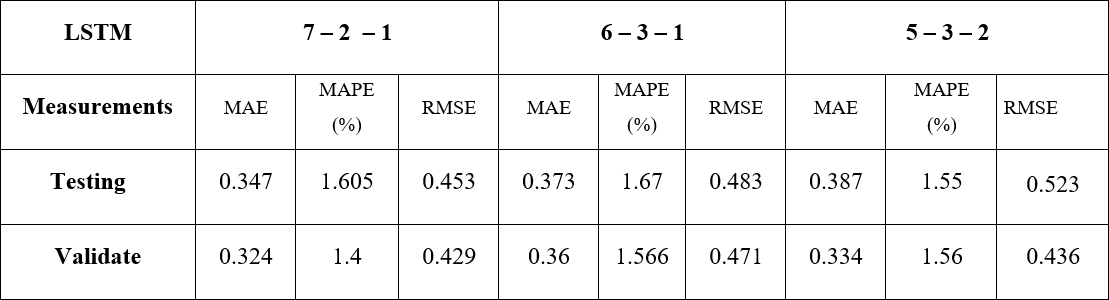